In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Libraries

In [2]:
def load_luxdata():
    my_luxdata = np.load('data/luxdata_avg_ph_npa.npy')
    my_luxdata = my_luxdata[4:24*7*2+4]
    my_luxdata = np.nan_to_num(my_luxdata, 1)
    my_luxdata[my_luxdata == 255] = 1
    luxdata = 1.39*10**8 * (255*497/my_luxdata - 497)**(-1.67)
    
    my_timestamp = np.load('data/timestamp.npy')
    timestamp = my_timestamp[4:24*7*2+4]
    
    return luxdata, timestamp

In [3]:
def load_supercap():
    my_supercap = np.load('data/supercap_avg_ph_npa.npy')
    my_supercap = my_supercap[4:24*7*2+4]
    my_supercap = np.nan_to_num(my_supercap, 1)
    supercap = my_supercap/100 * 3.6
    
    return supercap

In [4]:
def solar_current(A, lux, volt):
#     200 lux --> Isc = 47uA
#     I_0 = 1 * 10**-10
#     I_SC = 500 * 10**-6
    V_list = np.linspace(0,6,num=100)
    q = 1.602176634 * 10**-19
    k = 1.38064852 * 10**-23
    T = 293 #
    n = 35
    V_OC = 4.9
    j_density = 47/200 * 10**-6 / ((56.1 * 45.2) * 10**-6 )
    I_SC =  A * lux * j_density
    I_0 = I_SC / (np.exp(V_OC*q/(n*k*T))- 1)

    I_list = I_SC - I_0*(np.exp((V_list*q)/(n*k*T)) - 1)
    my_I = I_SC - I_0*(np.exp((volt*q)/(n*k*T)) - 1)
    return my_I, I_list, V_list

In [5]:
def find_opt_solar_panel_area(i_consume, luxdata):
    i_sp_per_m2 = np.mean(np.array([solar_current(1, lux, 3.6)[0] for lux in luxdata]))
    A = i_consume/i_sp_per_m2
    return A

In [6]:
def find_opt_sc_cap(i_solar, i_consume, V_sc_min = 2.1, V_sc_max =3.6):
    i_solar = np.array(i_solar)
    i_total = i_solar - i_consume
    
    t_neg = np.sum(i_solar <  i_consume)
    t_pos = np.sum(i_solar >= i_consume)
    t_total = len(i_solar)
    
    p_neg = t_neg/t_total
    p_pos = t_pos/t_total
    
    i_neg = -np.mean(i_total[i_total<0])
    i_pos = np.mean(i_total[i_total>=0])
    
    E_pos = (24*3600 * p_pos) * i_pos
    E_neg = (24*3600 * p_neg) * i_neg

    C_opt = np.minimum(E_pos, E_neg) / (V_sc_max - V_sc_min)
    return C_opt

In [7]:
def find_opt_sc_cap2(i_solar, i_consume, V_sc_min = 2.1, V_sc_max =3.6):
    t_unsus = np.sum(np.array(i_solar) < i_consume)
    t_sus = np.sum(np.array(i_solar) >= i_consume)
    t_total = len(i_solar)

    p_unsus = t_unsus/t_total
    p_sus = t_sus/t_total
    
    i_net = np.array(i_solar) - np.array(i_consume)
    i_net_neg = i_net[i_net < 0]
    
    C_opt = -np.sum(i_net_neg)*1.8*3600 / (1/2*(C*(3.6**2-2.1**2)))
    
    return C_opt

In [8]:
def gen_sc_v(C, A, luxdata, i_consume, V_sc_min = 2.1, V_sc_max =3.6):
    SDR = 5*10**-6 # in Amp
    V_start = V_sc_min
    V_curr = V_start

    V_list = []
    i_list = []

    for lux in luxdata:
        i_harvest, _, _ = solar_current(A, lux, V_curr)
        i_total = i_harvest - i_consume
        i_list.append(i_total)
    #     p_dvdt = i/C
    #     n_dvdt = (-SDR -i_consume)/C
        dvdt = i_total/C

        V_next = np.minimum(V_curr + 3600*dvdt, V_sc_max)
        V_next = np.maximum(V_next, V_sc_min)
        V_curr = V_next
        V_list.append(V_curr)
        
    V_list = np.array(V_list)
    return V_list, i_list

In [9]:
def calc_lifetime(V_sc_list, i_consume, log=True, batt_cap=1000 * 10**-3):
    t_sus = sum(V_sc_list > 2.1)
    t_unsus = sum(V_sc_list <= 2.1)
    t_total = len(V_sc_list)

    p_unsus = t_unsus/t_total
    p_sus = t_sus/t_total

    # batt_cap = 1000 * 10**-3 # in Ah

    i_consum_red = p_unsus * i_consume
    t_l_original = (batt_cap/i_consume)/(24*365)
    t_l_extended = (batt_cap/i_consum_red)/(24*365)
    
    if log: 
        print('Sustainable time: ' + "{:.2f}".format(p_sus*24) + ' hours')
        print('Unsustainable time: ' + "{:.2f}".format(p_unsus*24) + ' hours')

        print('Original lifetime: ' + "{:.2f}".format(t_l_original) + ' years')
        print('Extended lifetime: ' + "{:.2f}".format(t_l_extended) + ' years')

    return t_l_original, t_l_extended

In [10]:
def find_opt_luxbeacon(luxdata, i_consume, log=True):
    A = find_opt_solar_panel_area(i_consume, luxdata)
    # A = ((56.1 * 45.2) * 10**-6 )

    i_solar = [solar_current(A, lux, 3.6)[0] for lux in luxdata]
    C = find_opt_sc_cap(i_solar, i_consume)
    # C = 1.5

    V_sc_list, i_net_list = gen_sc_v(C, A, luxdata, i_consume)
    V_sc_gt = load_supercap()

    t_l_original, t_l_extended = calc_lifetime(V_sc_list, i_consume, log=log)
    if log: 
        print('Minimum SC capacity: ' + "{:.2f}".format(C) + ' F')
        print('Minimum SP area: ' + "{:.2f}".format(A*10**6) + ' mm^2')
        print('Lifetime extension: ' + "{:.2f}".format((t_l_extended/t_l_original - 1)*100) + ' %')
    
    return A, C, t_l_original, t_l_extended

In [11]:
def find_opt_luxbeacon2(luxdata, i_consume, batt_cap, A=None, C=None, log=True):
    if A == None:
        A = find_opt_solar_panel_area(i_consume, luxdata)

    i_solar = [solar_current(A, lux, 3.6)[0] for lux in luxdata]
    if C == None:
        C = find_opt_sc_cap(i_solar, i_consume)
        
    if log:
        print('Current consumption: ' + "{:.2f}".format(i_consume*10**6) + ' uA')
        print('Battery capacity: ' + "{:.2f}".format(batt_cap*10**3) + ' mAh')
        print('Minimum SP area: ' + "{:.2f}".format(A*10**6) + ' mm^2')
        print('Minimum SC capacity: ' + "{:.2f}".format(C) + ' F')

    V_sc_list, i_net_list = gen_sc_v(C, A, luxdata, i_consume)
    V_sc_gt = load_supercap()

    t_l_original, t_l_extended = calc_lifetime(V_sc_list, i_consume, batt_cap=batt_cap, log=log)
    
    if log: 
        print('Lifetime extension: ' + "{:.2f}".format((t_l_extended/t_l_original - 1)*100) + ' %')
    
    return A, C, t_l_original, t_l_extended

# Main script starts here

Current consumption: 30.00 uA
Minimum SP area: 917.79 mm^2
Minimum SC capacity: 1.11 F
Sustainable time: 20.71 hours
Unsustainable time: 3.29 hours
Original lifetime: 0.46 years
Extended lifetime: 3.34 years
Lifetime extension: 630.43 %


<ipython-input-2-2462293a3c56>:6: RuntimeWarning: divide by zero encountered in true_divide
  luxdata = 1.39*10**8 * (255*497/my_luxdata - 497)**(-1.67)


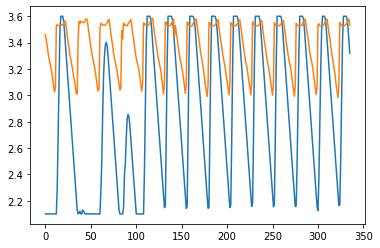

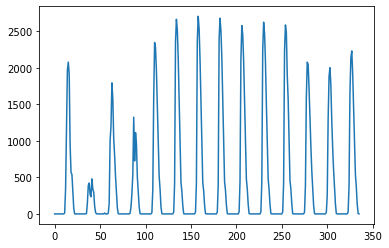

In [12]:
luxdata, timestamp = load_luxdata()
luxdata = luxdata / np.percentile(luxdata, 80, interpolation='higher') * 1000

i_consume = 30*10**-6
print('Current consumption: ' + "{:.2f}".format(i_consume*10**6) + ' uA')
A = find_opt_solar_panel_area(i_consume, luxdata)
# A = ((56.1 * 45.2) * 10**-6 )
print('Minimum SP area: ' + "{:.2f}".format(A*10**6) + ' mm^2')

i_solar = [solar_current(A, lux, 3.6)[0] for lux in luxdata]
C = find_opt_sc_cap(i_solar, i_consume)
# C = 1.5
print('Minimum SC capacity: ' + "{:.2f}".format(C) + ' F')

V_sc_list, i_net_list = gen_sc_v(C, A, luxdata, i_consume)
V_sc_gt = load_supercap()

t_l_original, t_l_extended = calc_lifetime(V_sc_list, i_consume, batt_cap=120*10**-3)
print('Lifetime extension: ' + "{:.2f}".format((t_l_extended/t_l_original - 1)*100) + ' %')

plt.plot(V_sc_list)
plt.plot(V_sc_gt)
plt.figure()
plt.plot(luxdata)